<a href="https://colab.research.google.com/github/snpushpi/Differential-Privacy-in-Split-Learning/blob/main/practice_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [37]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [38]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)
from torch.utils.data.sampler import SubsetRandomSampler

total_size = len(trainset)

split1 = total_size // 4
split2 = split1*2
split3 = split1*3

indices = list(range(total_size))

alice_idx = indices[:split1]
bob_idx = indices[split1:split2]
mike_idx = indices[split2:split3]
rose_idc = indices[split3:]

alice_sampler = SubsetRandomSampler(alice_idx)
bob_sampler = SubsetRandomSampler(bob_idx)
mike_sampler = SubsetRandomSampler(mike_idx)
rose_sampler = SubsetRandomSampler(rose_idc)


alice_loader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=alice_sampler)
bob_loader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=bob_sampler)
mike_loader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=mike_sampler)
rose_loader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=rose_sampler)

data_loaders = [alice_loader, bob_loader, mike_loader, rose_loader ]

print(f'Data at alice: {len(alice_sampler)} \t Batches: {len(alice_loader)}')
print(f'Data at bob: {len(bob_sampler)} \t Batches: {len(alice_loader)}')
print(f'Data at mike: {len(mike_sampler)} \t Batches: {len(mike_loader)}')
print(f'Data at rose: {len(rose_sampler)} \t Batches: {len(rose_loader)}')

Data at alice: 15000 	 Batches: 235
Data at bob: 15000 	 Batches: 235
Data at mike: 15000 	 Batches: 235
Data at rose: 15000 	 Batches: 235


In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


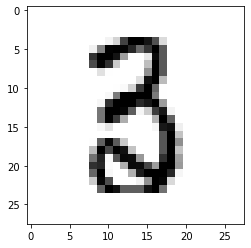

In [ ]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

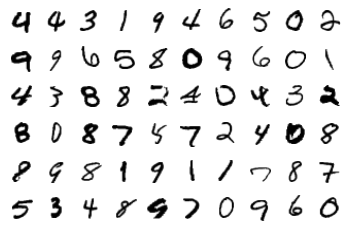

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [39]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10
import copy
client_model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU()
                      )
alice_model = copy.deepcopy(client_model)
bob_model = copy.deepcopy(client_model)
mike_model = copy.deepcopy(client_model)
rose_model = copy.deepcopy(client_model)

server_model = nn.Sequential(
  nn.Linear(hidden_sizes[1], output_size),
  nn.LogSoftmax(dim=1)
)
models = [alice_model, bob_model, mike_model, rose_model]

# Create optimizers for each model
#optimizers = [optim.Adam(model.parameters(), lr=0.01) for model in models]

In [40]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [ ]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0020, -0.0020, -0.0020,  ..., -0.0020, -0.0020, -0.0020],
        [ 0.0006,  0.0006,  0.0006,  ...,  0.0006,  0.0006,  0.0006],
        [ 0.0011,  0.0011,  0.0011,  ...,  0.0011,  0.0011,  0.0011],
        ...,
        [-0.0028, -0.0028, -0.0028,  ..., -0.0028, -0.0028, -0.0028],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0004, -0.0004, -0.0004,  ..., -0.0004, -0.0004, -0.0004]])


In [ ]:
import numpy as np
import scipy
from scipy import linalg
class RONGauss:
    """RON-Gauss: Synthesizing Data with Differential Privacy
    This module implements RON-Gauss, which is a method for non-interactive differentially-private data release based on 
    random orthornormal (RON) projection and Gaussian generative model. RON-Gauss leverages the Diaconis-Freedman-Meckes (DFM) effect,
    which states that most random projections of high-dimensional data approaches Gaussian.
    The main method of the `RONGauss` class is `_generate_dpdata()`. It takes in the original data as inputs, and, depending
    on the algorithm chosen, returns the differentially private data.
    
    Parameters
    ----------
    algorithm : string {'supervised', 'unsupervised', 'gmm'}
        supervised : 
            implements RON-Gauss for supervised learning, especially for regression. This algorithm
            requires both the feature data and the target label as inputs. In addition, it requires
            `max_y` to be specified.
        unsupervised :
            implements RON-Gauss for unsupervised learning, so only the feature data are required.
            This mode will return `None` for `dp_y`.
        gmm :
            implements RON-Gauss for classification. This algorithm requires both the feature data
            and the target label as inputs. The target label has to be categorical.
    epsilon_mean : float (default 1.0)
        The privacy budget for computing the mean. The sum of `epsilon_mean` and `epsilon_cov` is the total
        privacy budget spent.
    epsilon_cov : float (default 1.0)
        The privacy budget for computing the covariance. The sum of `epsilon_mean` and `epsilon_cov` is the total
        privacy budget spent.
    
    
    Examples
    -------
    >>> import numpy as np
    >>> X = np.random.normal(size=(1000,100))
    >>> dim = 10
    >>> # try unsupervised
    >>> rongauss_unsup = ron_gauss.RONGauss(algorithm='unsupervised')
    >>> dp_x, _ = rongauss_unsup.generate_dpdata(X, dim)
    >>> # try supervised
    >>> y = np.random.uniform(low=0.0, high=1.0, size=1000)
    >>> rongauss_sup = ron_gauss.RONGauss(algorithm='supervised')
    >>> dp_x, dp_y = rongauss_sup.generate_dpdata(X, dim, y, max_y = 1.0)
    >>> # try gmm
    >>> y = np.random.choice([0,1], size=1000)
    >>> rongauss_gmm = ron_gauss.RONGauss(algorithm='gmm')
    >>> dp_x, dp_y = rongauss_gmm.generate_dpdata(X, dim, y)
    """
    
    def __init__(self, algorithm="supervised", epsilon_mean=1.0, epsilon_cov=1.0):
        self.algorithm = algorithm
        self.epsilon_mean = epsilon_mean
        self.epsilon_cov = epsilon_cov

    def generate_dpdata(
        self,
        X,
        dimension,
        y=None,
        max_y=None,
        n_samples=None,
        reconstruct=True,
        centering=False,
        prng_seed=None,
    ):
        """Generate differentially-private dataset using RON-Gauss
        Parameters
        ----------
        X : numpy.ndarray, shape = [N_samples, M_features]
            Feature data.
        dimension : int < M_features
            The dimension for the data to be reduced to.
        y : numpy.ndarray, shape = [n_samples] (default None)
            Target values.
            unsupervised : this parameter is not used.
            supervised : required.
            gmm : required and the values should be categorical.
        n_samples : int (default None)
            The number of samples to be synthesized. If None is passed, the returned number of samples will
            be equal to N_samples of X.
        max_y : float (default None)
            The maximum absolute value that the target label can take. For example, if y is [0,1], then
            max_y = 1. If y is [-2,1], then max_y = 2. This is required and used by the supervised
            algorithm only.
        reconstruct : bool (default True)
            An option to reconstrut the projected synthesized data back to the original space. If True, the
            returned data will have the same dimension as X. If False, the returned data will have the dimension
            specified by the parameter `dimension`.
        centering : bool (default False)
            An option to automatically center the synthesized data. If False, the mean will be the
            differentially-private mean derived from X. This parameter is always False for 'gmm'.
        prng_seed : int (default None)
            This is to specify the seed used in randomized algorithms used.
        
        Returns
        -------
        x_dp : numpy.ndarray, shape = [n_samples, M_features] or [n_samples, dimensions]
            The differentially-private feature data. If `reconstruct` is True, this will be [n_samples, M_features].
            If `reconstruct` is False, it will be [n_samples, dimensions].
        y_dp : numpy.ndarray, shape = [n_samples]
            For `unsupervised`, this will be None.
            For `supervised` and `gmm`, this will be the differentially private target label.
        """
        (n, m) = X.shape
        if n_samples is None:
            n_samples = n

        if self.algorithm == "unsupervised":
            x_dp = self._unsupervised_rongauss(X, dimension, n_samples, reconstruct, centering, prng_seed)
            y_dp = None

        elif self.algorithm == "supervised":
            x_dp, y_dp = self._supervised_rongauss(X, dimension, y, n_samples, max_y, reconstruct, centering, prng_seed)

        elif self.algorithm == "gmm":
            x_dp, y_dp = self._gmm_rongauss(X,dimension, y, n_samples, reconstruct, prng_seed)
        
        return (x_dp, y_dp)
    
    def _unsupervised_rongauss(
        self,
        X,
        dimension,
        n_samples,
        reconstruct,
        centering,
        prng_seed,
    ):
        """Generate differentially-private dataset using the unsupervised RON-Gauss
        Parameters
        ----------
        X : numpy.ndarray, shape = [N_samples, M_features]
            Feature data.
        dimension : int < M_features
            The dimension for the data to be reduced to.
        n_samples : int (default None)
            The number of samples to be synthesized. If None is passed, the returned number of samples will
            be equal to N_samples of X.
        reconstruct : bool (default True)
            An option to reconstrut the projected synthesized data back to the original space. If True, the
            returned data will have the same dimension as X. If False, the returned data will have the dimension
            specified by the parameter `dimension`.
        centering : bool (default False)
            An option to automatically center the synthesized data. If False, the mean will be the
            differentially-private mean derived from X. This parameter is always False for 'gmm'.
        prng_seed : int (default None)
            This is to specify the seed used in randomized algorithms used.
        
        Returns
        -------
        x_dp : numpy.ndarray, shape = [n_samples, M_features] or [n_samples, dimensions]
            The differentially-private feature data. If `reconstruct` is True, this will be [n_samples, M_features].
            If `reconstruct` is False, it will be [n_samples, dimensions].
        """
        prng = np.random.RandomState(prng_seed)
        (x_bar, mu_dp) = self._data_preprocessing(X, self.epsilon_mean, prng)
        (x_tilda, proj_matrix) = self._apply_ron_projection(x_bar, dimension, prng)
        (n, p) = x_tilda.shape
        noise_var = (2.0 * np.sqrt(p)) / (n * self.epsilon_cov)
        cov_matrix = np.inner(x_tilda.T, x_tilda.T) / n
        laplace_noise = prng.laplace(scale=noise_var, size=(p, p))
        cov_dp = cov_matrix + laplace_noise
        synth_data = prng.multivariate_normal(np.zeros(p), cov_dp, n_samples)
        x_dp = synth_data
        if reconstruct:
            x_dp = self._reconstruction(x_dp, proj_matrix)
        else:
            #project the mean down to the lower dimention
            mu_dp = np.inner(mu_dp, proj_matrix)
        self._mu_dp = mu_dp

        if not centering:
            x_dp = x_dp + mu_dp
        return x_dp

    def _supervised_rongauss(
        self,
        X,
        dimension,
        y,
        n_samples,
        max_y,
        reconstruct,
        centering,
        prng_seed,
    ):  
        """Generate differentially-private dataset using the supervised RON-Gauss
        Parameters
        ----------
        X : numpy.ndarray, shape = [N_samples, M_features]
            Feature data.
        dimension : int < M_features
            The dimension for the data to be reduced to.
        y : numpy.ndarray, shape = [n_samples] (default None)
            Target values.
        n_samples : int (default None)
            The number of samples to be synthesized. If None is passed, the returned number of samples will
            be equal to N_samples of X.
        max_y : float
            The maximum absolute value that the target label can take. For example, if y is [0,1], then
            max_y = 1. If y is [-2,1], then max_y = 2.
        reconstruct : bool (default True)
            An option to reconstrut the projected synthesized data back to the original space. If True, the
            returned data will have the same dimension as X. If False, the returned data will have the dimension
            specified by the parameter `dimension`.
        centering : bool (default False)
            An option to automatically center the synthesized data. If False, the mean will be the
            differentially-private mean derived from X. This parameter is always False for 'gmm'.
        prng_seed : int (default None)
            This is to specify the seed used in randomized algorithms used.
        
        Returns
        -------
        x_dp : numpy.ndarray, shape = [n_samples, M_features] or [n_samples, dimensions]
            Differentially-private feature data. If `reconstruct` is True, this will be [n_samples, M_features].
            If `reconstruct` is False, it will be [n_samples, dimensions].
        y_dp : numpy.ndarray, shape = [n_samples]
            Differentially private target label.
        """

        prng = np.random.RandomState(prng_seed)
        (x_bar, mu_dp) = self._data_preprocessing(X, self.epsilon_mean, prng)
        (x_tilda, proj_matrix) = self._apply_ron_projection(x_bar, dimension, prng)

        (n, p) = x_tilda.shape
        noise_var = (2.0 * np.sqrt(p) + 4.0 * np.sqrt(p) * max_y + max_y ** 2) / (
            n * self.epsilon_cov
        )
        y_reshaped = y.reshape(len(y), 1)
        augmented_mat = np.hstack((x_tilda, y_reshaped))
        cov_matrix = np.inner(augmented_mat.T, augmented_mat.T) / n
        laplace_noise = prng.laplace(scale=noise_var, size=cov_matrix.shape)
        cov_dp = cov_matrix + laplace_noise

        synth_data = prng.multivariate_normal(np.zeros(p + 1), cov_dp, n_samples)
        x_dp = synth_data[:, 0:-1]
        y_dp = synth_data[:, -1]
        if reconstruct:
            x_dp = self._reconstruction(x_dp, proj_matrix)
        else:
            #project the mean down to the lower dimention
            mu_dp = np.inner(mu_dp, proj_matrix)
        self._mu_dp = mu_dp

        if not centering:
            x_dp = x_dp + mu_dp
        
        return (x_dp, y_dp)

    def _gmm_rongauss(
        self,
        X,
        dimension,
        y,
        n_samples,
        reconstruct,
        prng_seed,
    ):
        """Generate differentially-private dataset using the GMM RON-Gauss
        Parameters
        ----------
        X : numpy.ndarray, shape = [N_samples, M_features]
            Feature data.
        dimension : int < M_features
            The dimension for the data to be reduced to.
        y : numpy.ndarray, shape = [n_samples] (default None)
            Target values, which hould be categorical.
        n_samples : int (default None)
            The number of samples to be synthesized. If None is passed, the returned number of samples will
            be equal to N_samples of X.
        reconstruct : bool (default True)
            An option to reconstrut the projected synthesized data back to the original space. If True, the
            returned data will have the same dimension as X. If False, the returned data will have the dimension
            specified by the parameter `dimension`.
        centering : bool (default False)
            An option to automatically center the synthesized data. If False, the mean will be the
            differentially-private mean derived from X. This parameter is always False for 'gmm'.
        prng_seed : int (default None)
            This is to specify the seed used in randomized algorithms used.
        
        Returns
        -------
        x_dp : numpy.ndarray, shape = [n_samples, M_features] or [n_samples, dimensions]
            Differentially-private feature data. If `reconstruct` is True, this will be [n_samples, M_features].
            If `reconstruct` is False, it will be [n_samples, dimensions].
        y_dp : numpy.ndarray, shape = [n_samples]
            Differentially private target label.
        """
        prng = np.random.RandomState(prng_seed)
        syn_x = None
        syn_y = np.array([])
        for label in np.unique(y):
            idx = np.where(y == label)
            x_class = X[idx]
            (x_bar, mu_dp) = self._data_preprocessing(x_class, self.epsilon_mean, prng)
            (x_tilda, proj_matrix) = self._apply_ron_projection(x_bar, dimension, prng)

            (n, p) = x_tilda.shape
            noise_var = (2.0 * np.sqrt(p)) / (n * self.epsilon_cov)
            mu_dp_tilda = np.inner(mu_dp, proj_matrix)
            cov_matrix = np.inner(x_tilda.T, x_tilda.T) / n
            laplace_noise = prng.laplace(scale=noise_var, size=(p, p))
            cov_dp = cov_matrix + laplace_noise
            synth_data = prng.multivariate_normal(mu_dp_tilda, cov_dp, n_samples)

            if reconstruct:
                synth_data = self._reconstruction(synth_data, proj_matrix)
            if syn_x is None:
                syn_x = synth_data
            else:
                syn_x = np.vstack((syn_x, synth_data))
                
            syn_y = np.append(syn_y, label * np.ones(n_samples))
        return syn_x, syn_y

    @staticmethod
    def _data_preprocessing(X, epsilon_mean, prng=None):
        """
        This is the DATA_PREPROCESSING algorithm based on Algo. 1 in the paper.
        Parameters
        ----------
        X : numpy.ndarray, shape = [N_samples, M_features]
            Feature data.
        epsilon_mean : float
            The privacy budget used for computing the mean.
        prng_seed : int (default None)
            This is to specify the seed used in randomized algorithms used.
        
        Returns
        -------
        x_bar : numpy.ndarray, shape = [N_samples, M_features]
            The pre-processed data which are pre-normalized, centered, and re-normalized.
        mean_dp : numpy.ndarray, shape = [M_features]
            The differentially-private mean used in the centering.
        """
        if prng is None:
            prng = np.random.RandomState()
        (n, m) = X.shape
        # pre-normalize
        x_norm = RONGauss._normalize_sample_wise(X)
        # derive dp-mean
        mu = np.mean(x_norm, axis=0)
        noise_var_mu = np.sqrt(m) / (n * epsilon_mean)
        laplace_noise = prng.laplace(scale=noise_var_mu, size=m)
        mean_dp = mu + laplace_noise
        # centering
        x_bar = x_norm - mean_dp
        # re-normalize
        x_bar = RONGauss._normalize_sample_wise(x_bar)
        return x_bar, mean_dp

    def _apply_ron_projection(self, x_bar, dimension, prng=None):
        """
        This is the RON_PROJECTION algorithm based on Algo. 2 in the paper.
        Parameters
        ----------
        x_bar : numpy.ndarray, shape = [N_samples, M_features]
            Feature data.
        dimension : int < M_features
            The dimension for the data to be reduced to.
        prng_seed : int (default None)
            This is to specify the seed used in randomized algorithms used.
        
        Returns
        -------
        x_tilda : numpy.ndarray, shape = [N_samples, dimension]
            The dimension-reduced data.
        ron_matrix : numpy.ndarray, shape = [dimension, M_features]
            The RON projection matrix used for dimensionality reduction.
        """
        (n, m) = x_bar.shape
        full_projection_matrix = self._generate_ron_matrix(m, prng)
        ron_matrix = full_projection_matrix[0:dimension]  # take the rows
        x_tilda = np.inner(x_bar, ron_matrix)
        return x_tilda, ron_matrix

    def _reconstruction(self, x_projected, ron_matrix):
        """
        The function used to project the dimension-reduced data back to the original space.
        Parameters
        ----------
        x_projected : numpy.ndarray, shape = [N_samples, P_dimension]
            The dimension-reduced data.
        ron_matrix : numpy.ndarray, shpae = [P_dimension, M_features]
            The RON projection matrix used to produce the dimension-reduced data.
        
        Returns
        -------
        x_reconstructed : numpy.ndarray, shape = [N_samples, M_features]
            The reconstructed data.
        """
        x_reconstructed = np.inner(x_projected, ron_matrix.T)
        return x_reconstructed

    def _generate_ron_matrix(self, m, prng=None):
        """
        Generate a RON projection matrix using QR factorization.
        Parameters
        ----------
        m : int
            The dimension of the projection matrix.
        prng_seed : int (default None)
            This is to specify the seed used in randomized algorithms used.
        
        Returns
        -------
        ron_matrix : numpy.ndarray, shape = [m, m]
            The RON projection matrix.
        """
        if prng is None:
            prng = np.random.RandomState()
        # generate random matrix
        random_matrix = prng.uniform(size=(m, m))
        # QR factorization
        q_matrix, r_matrix = scipy.linalg.qr(random_matrix) #numpy.linalg.qr(random_matrix, mode='complete')
        ron_matrix = q_matrix
        return ron_matrix
        
    @staticmethod
    def _normalize_sample_wise(x):
        """
        Sample-wise normalization
        Parameters
        ----------
        x : numpy.ndarray, shape = [N_samples, M_features]
            Feature data.
        
        Returns
        -------
        x_normalized : numpy.ndarray, shape = [N_samples, M_features]
            The sample-wise normalized data
        """
        (n,p) = x.shape
        sample_norms = np.linalg.norm(x, axis=1) #norms of each sample
        x_normalized = x/(np.outer(sample_norms,np.ones(p)))
        return x_normalized

In [42]:
optimizer = [optim.Adam(model.parameters(), lr=0.01) for model in models]
server_optimizer = optim.Adam(server_model.parameters(), lr=0.01)
server_loss = nn.CrossEntropyLoss()
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for i in range(4):
        for opt in optimizers:
            opt.zero_grad()
        server_optimizer.zero_grad()
        lst_of_vars = []
        for images, labels in data_loaders[i]:
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)
        
            split_output = models[i](images)
            split_layer_output = split_output.clone().detach().requires_grad_(True)
            server_output = server_model(split_layer_output)
            loss = server_loss(server_output, labels)
            lst_of_vars.append({'split_output': split_output, 'split_layer_output': split_layer_output, 'loss':loss})
        loss = 0 
        for j in range(4):
            loss+=lst_of_vars[j]['loss']
        avg_loss = loss/ len(data_loaders)
        running_loss+=avg_loss
        avg_loss.backward()
        for l in range(4):
            split_gradients = lst_of_vars[l]['split_layer_output'].grad.clone().detach()
            lst_of_vars[l]['split_output'].backward(split_gradients)
        server_optimizer.step()

        for opt in optimizers:
            opt.step()
            #This is where the model learns by backpropagating
            
    print("Epoch {} - Training loss: {}".format(e, running_loss/len(data_loaders[0])))


Epoch 0 - Training loss: 0.03882794454693794
Epoch 1 - Training loss: 0.038341768085956573
Epoch 2 - Training loss: 0.03766841068863869
Epoch 3 - Training loss: 0.037257079035043716
Epoch 4 - Training loss: 0.03649219870567322
Epoch 5 - Training loss: 0.036216504871845245
Epoch 6 - Training loss: 0.03554282337427139
Epoch 7 - Training loss: 0.03519881144165993
Epoch 8 - Training loss: 0.03468383476138115
Epoch 9 - Training loss: 0.03434985876083374
Epoch 10 - Training loss: 0.03394608572125435
Epoch 11 - Training loss: 0.033395759761333466
Epoch 12 - Training loss: 0.033109039068222046
Epoch 13 - Training loss: 0.03237692266702652
Epoch 14 - Training loss: 0.03238929808139801


In [ ]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 8


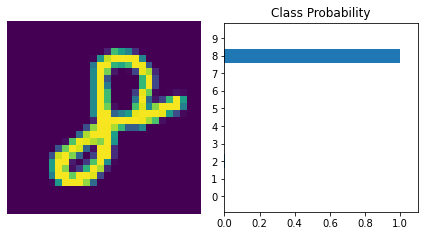

In [ ]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [ ]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img)

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))


Number Of Images Tested = 10000

Model Accuracy = 0.0876
